In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats, special, optimize

from infohdp.generators import gen_prior_pij, gen_prior_pij_t, gen_samples_prior, gen_samples_prior_t
from infohdp.core import entropy_true, mutual_information_true
from infohdp.utils import count_nxy_multiclass
from infohdp.estimators import NaiveEstimator, NSBEstimator, BinaryInfoHDPEstimator, MulticlassInfoHDPEstimator, BinaryFullInfoHDPEstimator, MulticlassFullInfoHDPEstimator

# Or import the whole package as "import infohdp"

In [7]:
# Example 1: Generate prior pij, binary case
alpha = 200.0
beta = 2.5
Ns = 10000

# Example 2: Generate prior pij_t, multiclass case
qy = [0.6, 0.3, 0.1]  # Example marginal distribution for Y
pi, pjdadoi, pij_t = gen_prior_pij_t(alpha, beta, qy, Ns)

In [8]:
print(pij_t.shape)

print(f"True entropy: {entropy_true(pij_t):.4f}")
print(f"Effective number of states: {np.exp(entropy_true(pij_t)):.4f}")

# Set the seed
np.random.seed(1)
M = 500
samples_t = gen_samples_prior_t(pi,pjdadoi, M, Ns)

# Create instances of Estimators for multiclass case
naive_estimator = NaiveEstimator()
nsb_estimator = NSBEstimator()
ihdpt_estimator = MulticlassInfoHDPEstimator()
ihdpfull_estimator = MulticlassFullInfoHDPEstimator()

print(f"Naive entropy: {naive_estimator.estimate_entropy(samples_t):.4f}")
s_nsb, ds_nsb = nsb_estimator.estimate_entropy(samples_t)
print(f"NSB entropy: {s_nsb:.4f} ± {ds_nsb:.4f}")

print(f"True mutual information: {mutual_information_true(pij_t):.4f}")
print(f"Naive info: {naive_estimator.estimate_mutual_information(samples_t):.4f}")
i_nsb, di_nsb = nsb_estimator.estimate_mutual_information(samples_t)
print(f"NSB info: {i_nsb:.4f} ± {di_nsb:.4f}")
print(f"Ihdp(MAP)T info: {ihdpt_estimator.estimate_mutual_information(samples_t):.4f}")

i_hdp, di_hdp = ihdpfull_estimator.estimate_mutual_information(samples_t)
print(f"Ihdp full multiclass info: {i_hdp:.4f} ± {di_hdp:.4f}")


(10000, 3)
True entropy: 6.3816
Effective number of states: 590.8459
Naive entropy: 5.4049
NSB entropy: 6.1874 ± 0.0813
True mutual information: 0.2803
Naive info: 0.5457
NSB info: 0.3052 ± 0.1130
Ihdp(MAP)T info: 0.2286
Ihdp full multiclass info: 0.2278 ± 0.0427


In [ ]:
# Figure where we plot the average estimation of mutual information for different number of samples (from 50 to 2000, moving in log space) for the three estimators, naive, nsb and ihdp. For each number of samples we generate 20 sets of samples and compute the average and standard deviation of the estimation.

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def hdp_estimator(samples):
    estimator = MulticlassFullInfoHDPEstimator()
    i_hdp, _ = estimator.estimate_mutual_information(samples)
    return i_hdp

def nsb_estimator(samples):
    estimator = NSBEstimator()
    i_nsb, _ = estimator.estimate_mutual_information(samples)
    return i_nsb

def naive_estimator(samples):
    estimator = NaiveEstimator()
    i_naive = estimator.estimate_mutual_information(samples)
    return i_naive

def estimate_mutual_information(pi, pjdadoi, Ns, naive_estimator, nsb_estimator, hdp_estimator, sample_sizes):
    """
    Estimate mutual information using Naive Estimator, NSB Estimator, and HDP Estimator for different sample sizes.
    
    Parameters:
    - pi: Prior distribution parameter.
    - pjdadoi: Conditional distribution parameter.
    - Ns: Number of states.
    - naive_estimator: Function to estimate mutual information using Naive Estimator.
    - nsb_estimator: Function to estimate mutual information using NSB Estimator.
    - hdp_estimator: Function to estimate mutual information using HDP Estimator.
    - sample_sizes: List of sample sizes to use for estimation.
    
    Returns:
    - results: A dictionary containing the averaged mutual information estimates and standard deviations for each estimator.
    """
    
    results = {
        'naive': {'mean': [], 'std': []},
        'nsb': {'mean': [], 'std': []},
        'hdp': {'mean': [], 'std': []}
    }
    
    for sample_size in sample_sizes:
        naive_estimates = []
        nsb_estimates = []
        hdp_estimates = []
        
        for _ in range(20):  # Generate 20 sets of samples
            sample_data = gen_samples_prior_t(pi, pjdadoi, sample_size, Ns)
            
            naive_estimates.append(naive_estimator(sample_data))
            nsb_estimates.append(nsb_estimator(sample_data))
            hdp_estimates.append(hdp_estimator(sample_data))
        
        results['naive']['mean'].append(np.mean(naive_estimates))
        results['naive']['std'].append(np.std(naive_estimates))
        results['nsb']['mean'].append(np.mean(nsb_estimates))
        results['nsb']['std'].append(np.std(nsb_estimates))
        results['hdp']['mean'].append(np.mean(hdp_estimates))
        results['hdp']['std'].append(np.std(hdp_estimates))
    
    return results

# Example usage:
# Assuming you have defined functions naive_estimator, nsb_estimator, and hdp_estimator
# pi = ...  # Your prior distribution parameter
# pjdadoi = ...  # Your conditional distribution parameter
# Ns = ...  # Number of states
sample_sizes = np.logspace(np.log10(50), np.log10(2000), num=20, dtype=int)
# results = estimate_mutual_information(pi, pjdadoi, Ns, naive_estimator, nsb_estimator, hdp_estimator, sample_sizes)

In [15]:
results = estimate_mutual_information(pi, pjdadoi, Ns, naive_estimator, nsb_estimator, hdp_estimator, sample_sizes)

/Users/dgherna/Dropbox/Pendientes/infohdpy/infohdp/estimators/multiclass_full_infohdp.py:45: RuntimeWarning: invalid value encountered in sqrt
  dsint = np.sqrt(s2int - sint**2) # TODO: extra checks here


In [16]:
# Plotting the results
def plot_results(results, sample_sizes):
    naive_means = results['naive']['mean']
    naive_stds = results['naive']['std']
    nsb_means = results['nsb']['mean']
    nsb_stds = results['nsb']['std']
    hdp_means = results['hdp']['mean']
    hdp_stds = results['hdp']['std']
    
    plt.figure(figsize=(10, 6))
    
    plt.errorbar(sample_sizes, naive_means, yerr=naive_stds, label='Naive Estimator', marker='o', capsize=5)
    plt.errorbar(sample_sizes, nsb_means, yerr=nsb_stds, label='NSB Estimator', marker='o', capsize=5)
    plt.errorbar(sample_sizes, hdp_means, yerr=hdp_stds, label='HDP Estimator', marker='o', capsize=5)
    
    plt.xlabel('Number of Samples')
    plt.ylabel('Mutual Information Estimate')
    plt.title('Mutual Information Estimates vs. Number of Samples')
    plt.legend()
    plt.grid(True)
    plt.xscale('log')
    plt.show()
    
# Example usage:
# plot_results(results, sample_sizes)

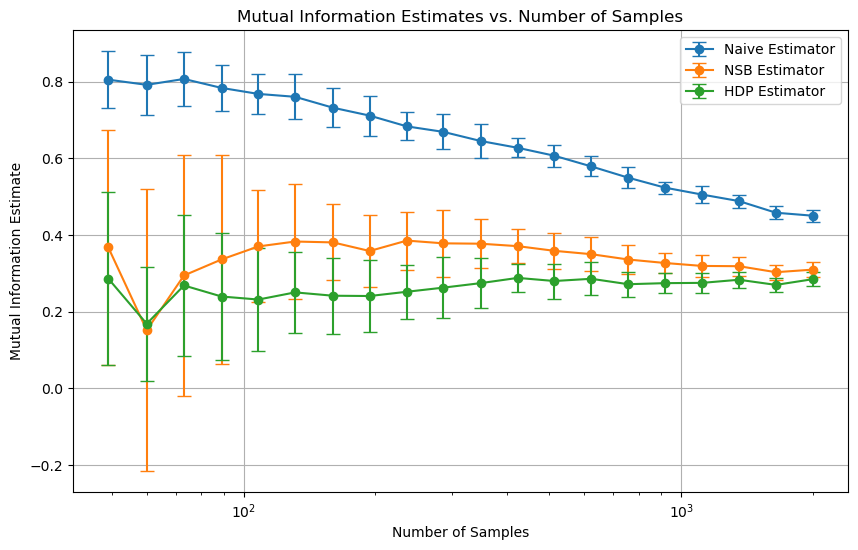

In [17]:
plot_results(results, sample_sizes)

In [18]:
# Export results to csv file

import pandas as pd

# Assuming 'results' is your dictionary containing the results
# Example structure of results:
# results = {
#     'naive': {'mean': [0.1, 0.2, 0.3], 'std': [0.01, 0.02, 0.03]},
#     'nsb': {'mean': [0.15, 0.25, 0.35], 'std': [0.015, 0.025, 0.035]},
#     'hdp': {'mean': [0.2, 0.3, 0.4], 'std': [0.02, 0.03, 0.04]}
# }

# Convert the results dictionary to a DataFrame
df_naive = pd.DataFrame(results['naive'])
df_nsb = pd.DataFrame(results['nsb'])
df_hdp = pd.DataFrame(results['hdp'])

# Add a column to identify the estimator
df_naive['estimator'] = 'naive'
df_nsb['estimator'] = 'nsb'
df_hdp['estimator'] = 'hdp'

# Concatenate all DataFrames
df_results = pd.concat([df_naive, df_nsb, df_hdp])

# Export the DataFrame to a CSV file
df_results.to_csv('results_synthetic.csv', index=False)

print("Results exported to results_synthetic.csv")

Results exported to results.csv
